In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import glob
from tqdm import tqdm
import tensorflow as tf
import keras 
from keras import layers
from keras.applications.mobilenet import preprocess_input
from PIL import Image


In [2]:
def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):
  filters = int(filters * alpha)
  x = layers.Conv2D(
      filters,
      kernel,
      padding='same',
      use_bias=False,
      strides=strides,
      name='conv1')(inputs)
  x = layers.BatchNormalization(name='conv1_bn')(x)
  return layers.ReLU(6., name='conv1_relu')(x)

In [3]:
def _depthwise_conv_block(inputs,
                          pointwise_conv_filters,
                          alpha,
                          depth_multiplier=1,
                          strides=(1, 1),
                          block_id=1):
  """Adds a depthwise convolution block.

  A depthwise convolution block consists of a depthwise conv,
  batch normalization, relu6, pointwise convolution,
  batch normalization and relu6 activation.

  Args:
    inputs: Input tensor of shape `(rows, cols, channels)` (with
      `channels_last` data format) or (channels, rows, cols) (with
      `channels_first` data format).
    pointwise_conv_filters: Integer, the dimensionality of the output space
      (i.e. the number of output filters in the pointwise convolution).
    alpha: controls the width of the network. - If `alpha` < 1.0,
      proportionally decreases the number of filters in each layer. - If
      `alpha` > 1.0, proportionally increases the number of filters in each
      layer. - If `alpha` = 1, default number of filters from the paper are
      used at each layer.
    depth_multiplier: The number of depthwise convolution output channels
      for each input channel. The total number of depthwise convolution
      output channels will be equal to `filters_in * depth_multiplier`.
    strides: An integer or tuple/list of 2 integers, specifying the strides
      of the convolution along the width and height. Can be a single integer
      to specify the same value for all spatial dimensions. Specifying any
      stride value != 1 is incompatible with specifying any `dilation_rate`
      value != 1.
    block_id: Integer, a unique identification designating the block number.
      # Input shape
    4D tensor with shape: `(batch, channels, rows, cols)` if
      data_format='channels_first'
    or 4D tensor with shape: `(batch, rows, cols, channels)` if
      data_format='channels_last'. # Output shape
    4D tensor with shape: `(batch, filters, new_rows, new_cols)` if
      data_format='channels_first'
    or 4D tensor with shape: `(batch, new_rows, new_cols, filters)` if
      data_format='channels_last'. `rows` and `cols` values might have
      changed due to stride.

  Returns:
    Output tensor of block.
  """

  pointwise_conv_filters = int(pointwise_conv_filters * alpha)

  if strides == (1, 1):
    x = inputs
  else:
    x = layers.ZeroPadding2D(((0, 1), (0, 1)), name='conv_pad_%d' % block_id)(
        inputs)
  x = layers.DepthwiseConv2D((3, 3),
                             padding='same' if strides == (1, 1) else 'valid',
                             depth_multiplier=depth_multiplier,
                             strides=strides,
                             use_bias=False,
                             name='conv_dw_%d' % block_id)(
                                 x)
  x = layers.BatchNormalization(
       name='conv_dw_%d_bn' % block_id)(
          x)
  x = layers.ReLU(6., name='conv_dw_%d_relu' % block_id)(x)

  x = layers.Conv2D(
      pointwise_conv_filters, (1, 1),
      padding='same',
      use_bias=False,
      strides=(1, 1),
      name='conv_pw_%d' % block_id)(
          x)
  x = layers.BatchNormalization(
       name='conv_pw_%d_bn' % block_id)(
          x)
  return layers.ReLU(6., name='conv_pw_%d_relu' % block_id)(x)

In [4]:
def MobileNet(input_shape=None,
              alpha=1.0,
              depth_multiplier=1,
              dropout=1e-3,
              include_top=True,
              weights='imagenet',
              input_tensor=None,
              pooling=None,
              classes=2,
              classifier_activation='softmax',
              **kwargs):

    img_input = layers.Input(shape=input_shape)
    
    x = _conv_block(img_input, 32, alpha, strides=(2, 2))
    x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)
    
    x = _depthwise_conv_block(
      x, 128, alpha, depth_multiplier, strides=(2, 2), block_id=2)
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)
    
    x = _depthwise_conv_block(
        x, 256, alpha, depth_multiplier, strides=(2, 2), block_id=4)
    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)
    
    x = _depthwise_conv_block(
        x, 512, alpha, depth_multiplier, strides=(2, 2), block_id=6)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)
    
    x = _depthwise_conv_block(
        x, 1024, alpha, depth_multiplier, strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)
    
    x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Reshape(shape, name='reshape_1')(x)
    # x = layers.Dropout(dropout, name='dropout')(x)
    # x = layers.Conv2D(classes, (1, 1), padding='same', name='conv_preds')(x)
    x = layers.Dense(2, name='fc')(x)
    x = layers.Reshape((classes,), name='reshape_1')(x)
    # imagenet_utils.validate_activation(classifier_activation, weights)
    x = layers.Activation(activation=classifier_activation,
                            name='predictions')(x)

    model = keras.Model(inputs=[img_input], outputs=[x])    
    return model

In [5]:
def zero_pad(img, size=224):
    '''
    pad zeros to make a square img for resize
    '''
    h, w, c = img.shape
    if h>w:
        zeros = np.zeros([h, h-w, c]).astype(np.uint8)
        img_padded = np.hstack((img, zeros))
    elif h<w:
        zeros = np.zeros([w-h, w, c]).astype(np.uint8)
        img_padded = np.vstack((img, zeros))
    else:
        img_padded = img
    
    img_resized = (255*resize(img_padded, (size, size), anti_aliasing=True)).astype(np.uint8)
    
    return img_resized

In [16]:
# load data
img_dirs = glob.glob(os.path.join('/media/wukai/project/breast_diff_resolustion_project/tumor_samples','*.jpg'))
model_weight = '/media/wukai/project/breast_diff_resolustion_project/MobileNet_224_checkpoints/2021913101.h5'
model = keras.models.load_model(model_weight)
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('conv_pw_13').output, model.output])

In [11]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    # 首先，我们创建一个模型，将输入图像映射到最后一个conv层的激活以及输出预测
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    #然后，我们为输入图像计算top预测类关于最后一个conv层的激活的梯度
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        #如果没有传入pred_index,就计算pred[0]中最大的值对应的下标号index
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)这是输出神经元(预测概率最高的或者选定的那个)对最后一个卷积层输出特征图的梯度
    # with regard to the output feature map of the last conv layer
    # grads.shape(1, 10, 10, 2048)
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient这是一个向量,每一项都是 指定特征图通道上的平均值
    # over a specific feature map channel
    # pooled_grads 是一个一维向量,shape=(2048,)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    # last_conv_layer_output[0]是一个三维的卷积层 ,@矩阵相乘(点积) 
    #last_conv_layer_output.shape  =(10, 10, 2048)
    last_conv_layer_output = last_conv_layer_output[0]
    #heatmap (10, 10, 1) = (10, 10, 2048)  @(2048,)相当于(10, 10, 2048)乘以(2048,1)
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    # tf.squeeze 去除1的维度,(10, 10)
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1	
    # tf.maximum(heatmap, 0) 和0比较大小,返回一个>=0的值,相当于relu,然后除以heatmap中最大的 值,进行normalize归一化到0-1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [12]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose重叠 the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

  0%|          | 0/4 [00:00<?, ?it/s]

001_3_0_0_roi tumor level: 3, predict: 2.1965091946185566e-05


/tmp/ipykernel_1812337/2769781665.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
 25%|██▌       | 1/4 [00:00<00:02,  1.06it/s]

008_4c_0_7_roi tumor level: 4c, predict: 0.9999827146530151


/tmp/ipykernel_1812337/2769781665.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
 50%|█████     | 2/4 [00:01<00:01,  1.33it/s]

004_5_0_3_roi tumor level: 5, predict: 0.9998910427093506


/tmp/ipykernel_1812337/2769781665.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
 75%|███████▌  | 3/4 [00:02<00:00,  1.42it/s]

002_3_0_1_roi tumor level: 3, predict: 0.0795985534787178


/tmp/ipykernel_1812337/2769781665.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


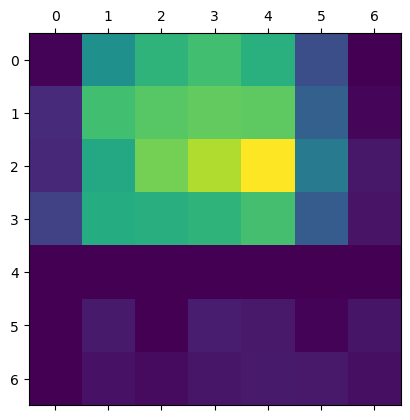

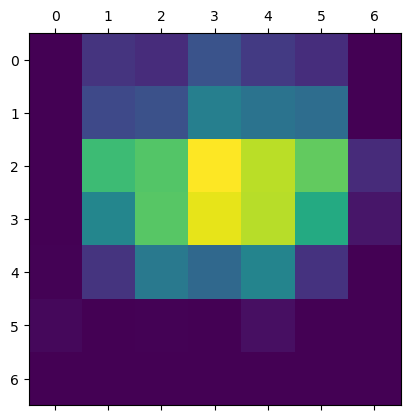

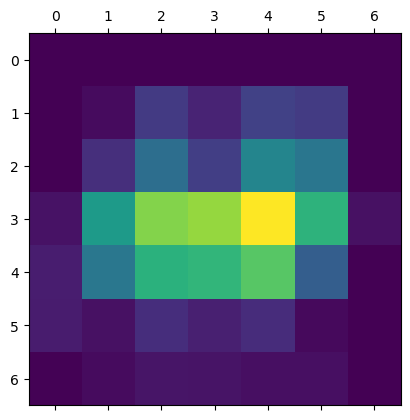

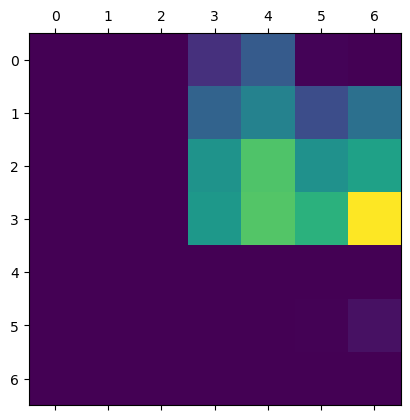

In [18]:
for img_dir in tqdm(img_dirs):
    img_name = os.path.basename(img_dir).replace('.jpg','')
    tumor_level = img_name.split('_')[1]
    img = Image.open(img_dir)
    img = np.array(img)
    img = zero_pad(img,224)
    x = preprocess_input(img)
    img_tensor = x.reshape(1,x.shape[0],x.shape[1],x.shape[2])
    y_pred = model.predict(img_tensor)
    print(f'{img_name} tumor level: {tumor_level}, predict: {y_pred[0][1]}')

    ### GRAD-CAM
    # Print what the top predicted class is
    preds = model.predict(img_tensor)
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_tensor, model, 'conv_pw_13')
    # Display heatmap
    plt.matshow(heatmap)
    plt.savefig(f'tumor_sample_cam/{img_name}_feat_heatmap.jpg')
    # Save and display Grad CAM
    save_and_display_gradcam(img_dir, heatmap, f'tumor_sample_cam/{img_name}_grad_cam.jpg')